# Imports

In [1]:
import sys
import os
PROJECT_ROOT = os.path.abspath("..")  # ajusta según tu estructura
sys.path.append(PROJECT_ROOT)

import json
from pathlib import Path
from xml.etree.ElementInclude import include

import numpy as np
import pandas as pd
import joblib
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import nn

from machine_learning.data_collectors import (
    build_ml_dataframe,
    build_supervised_dataset,
    time_split_masks,
    purged_ts_cv_splits,
    TARGET_HORIZONS,
    TARGET_LOOKBACKS,
)
from machine_learning.evaluators import eval_regression, eval_regression_extended

from python_scripts.LLM_analysis.preprocess_store_database import get_connection
from database_tier1 import TARGET_STOCKS

from typing import Tuple, Dict, List, Optional, Union, Iterable
from sklearn.preprocessing import StandardScaler

import torch
import random

[DB_PATH_DEFAULT] /home/aprohack/Desktop/all_folders/Investings_project/app/data/stock_data.db
{'foreign_keys': 1, 'journal_mode': 'wal', 'synchronous': 1}


In [2]:



def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_torch_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def assert_no_nan_inf(name: str, arr: np.ndarray) -> None:
    """Fail fast if data has NaNs/Infs."""
    if not np.isfinite(arr).all():
        bad = np.size(arr) - np.isfinite(arr).sum()
        raise ValueError(f"{name} has NaN/Inf values. Bad entries: {bad} / {arr.size}")



In [3]:

def fit_feature_scaler(X_train: pd.DataFrame) -> StandardScaler:
    scaler = StandardScaler().fit(X_train)
    return scaler

def transform_features(scaler: StandardScaler, X: pd.DataFrame, dtype=np.float32) -> np.ndarray:
    return scaler.transform(X).astype(dtype, copy=False)

def make_dataloaders(X_train_np, y_train_np, X_val_np, y_val_np, batch_size: int,
                     num_workers: int = 0, pin_memory: bool = False) -> Tuple[DataLoader, DataLoader]:
    
    train_ds = TensorDataset(
        torch.tensor(X_train_np, dtype=torch.float32),
        torch.tensor(y_train_np, dtype=torch.float32)
    )

    val_ds = TensorDataset(
        torch.tensor(X_val_np, dtype=torch.float32),
        torch.tensor(y_val_np, dtype=torch.float32)
    )

    train_dataloader = DataLoader(
        train_ds, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

    val_dataloader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

    return train_dataloader, val_dataloader


In [4]:
import matplotlib.pyplot as plt

def plot_mlp_training_curve(
    mlp_candidates: dict,
    key: str,
    *,
    show_lr: bool = True,
    smooth: int = 1,
):
    """
    Plot train/val loss curves for a given MLP candidate key (e.g. 'trial3').

    Args:
        mlp_candidates: dict holding candidates
        key: candidate key, e.g. 'trial3'
        show_lr: plot LR on secondary axis if available
        smooth: rolling window for smoothing losses (1 = no smoothing)
    """
    if key not in mlp_candidates:
        raise KeyError(f"{key} not found in mlp_candidates")

    hist = mlp_candidates[key].get("history", None)
    if hist is None:
        raise ValueError(f"No history found for {key}")

    epochs = hist.get("epoch", list(range(1, len(hist.get("train_loss", [])) + 1)))
    train_loss = hist.get("train_loss", [])
    val_loss = hist.get("val_loss", [])
    lr = hist.get("lr", None)

    if smooth and smooth > 1:
        import pandas as pd
        train_loss = pd.Series(train_loss).rolling(smooth).mean()
        val_loss = pd.Series(val_loss).rolling(smooth).mean()

    best_epoch = hist.get("best_epoch", None)
    best_val = hist.get("best_val_loss", None)

    fig, ax1 = plt.subplots()

    ax1.plot(epochs, train_loss, label="train_loss")
    ax1.plot(epochs, val_loss, label="val_loss")

    if best_epoch is not None and best_epoch > 0:
        ax1.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"best_epoch={best_epoch}")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title(f"MLP training curve — {key}")
    ax1.legend(loc="upper right")

    # Optional LR plot
    if show_lr and lr is not None:
        ax2 = ax1.twinx()
        ax2.plot(epochs, lr, color="gray", alpha=0.3, label="lr")
        ax2.set_ylabel("Learning rate")

    plt.tight_layout()
    plt.show()


In [5]:
from dataclasses import dataclass, asdict


@dataclass(frozen=True)
class MLPConfig:
    hidden_sizes: Tuple[int, ...] = (256, 128)
    dropout: float = 0.10
    batch_norm: bool = True

    lr: float = 1e-3
    weight_decay: float = 1e-4
    batch_size: int = 512

    max_epochs: int = 200
    patience: int = 20
    min_delta: float = 0.0
    grad_clip_norm: Optional[float] = 1.0

    seed: int = 42
    prefer_cuda: bool = True
    


In [6]:
class MLPRegressor(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_sizes: Iterable[int],
                 dropout: float = 0.1,
                 batch_norm: bool = True,):
        
        super().__init__()

        layers = []
        prev = input_dim
        for h in hidden_sizes:
            layers.append(
                nn.Linear(prev, h)
            )
            if batch_norm:
                layers.append(
                    nn.BatchNorm1d(h)
                )
            layers.append(
                nn.ReLU()
            )
            layers.append(
                nn.Dropout(dropout)
            )
            prev = h

        layers.append(
            nn.Linear(prev, 1)
        )

        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X).squeeze(-1)


        
    

In [7]:
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, loss_fn, device: torch.device, grad_clip_norm: float | None) -> float:
    # returns mean loss
    model.train()
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = loss_fn(yb, pred)
        loss.backward()

        if grad_clip_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)

        optimizer.step()
        losses.append(float(loss.detach().cpu().item()))

    mean_loss = np.mean(losses)
    return mean_loss.item()

def eval_one_epoch(model: nn.Module, loader: DataLoader, loss_fn, device: torch.device) -> float:
    # Returns mean loss
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            losses.append(float(loss.detach().cpu().item()))
    return np.mean(losses).item()

def fit_with_early_stopping(model: nn.Module, train_loader: DataLoader, validation_loader: DataLoader,
                            cfg: MLPConfig, device: torch.device) -> tuple[nn.Module, dict]:
    
    loss_fn = loss_fn = nn.SmoothL1Loss(beta=0.01)
    optimizer = torch.optim.AdamW(model.parameters(), cfg.lr, weight_decay=cfg.weight_decay)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.6,
        patience=max(2, cfg.patience // 4),
    )

    best_val = float("inf")
    best_epoch = -1
    best_state: Optional[dict] = None
    epochs_no_improve = 0

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "lr": [],
    }

    for epoch in range(1, cfg.max_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device, cfg.grad_clip_norm)
        val_loss = eval_one_epoch(model, validation_loader, loss_fn, device)


        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["lr"].append(float(optimizer.param_groups[0]["lr"]))

        scheduler.step(val_loss)

        if val_loss > best_val - cfg.min_delta:
            epochs_no_improve += 1
        else:
            best_val = val_loss
            best_epoch = epoch
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0

        if epoch % 10 == 0 or epoch == 1:
            print(f"epoch [{epoch}/{cfg.max_epochs}] - [train error: {train_loss:0.9f}, Val error: {val_loss:0.9f}]")


        if epochs_no_improve > cfg.patience:
            print("Early stopping")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    history["best_epoch"] = best_epoch # type: ignore
    history["best_val_loss"] = best_val # type: ignore

    return model, history



In [8]:
@torch.no_grad
def predict(model: nn.Module, loader: DataLoader, device: torch.device) -> np.ndarray:
    model.eval()
    preds: list[np.ndarray] = []

    for xb, _ in loader:
        xb = xb.to(device)
        pred = model(xb).detach().cpu().numpy()
        preds.append(pred)
    if not preds:
        return np.array([], dtype=np.float32)
    
    return np.concatenate(preds, axis=0)

In [9]:


def save_mlp_artifact(run_dir: str, model: nn.Module, scaler: StandardScaler, config: dict,
                    metrics: dict, feature_names: list[str], history: dict, pred_df_test: pd.DataFrame) -> None:
    
    p = Path(run_dir)
    p.mkdir(parents=True, exist_ok=True)

    model_payload = {
        "state_dict": model.state_dict(),
        "input_dim": int(len(feature_names)),
        "config": config.get("mlp_config", {}),
    }
    torch.save(model_payload, p / "model.pt")

    # StandardScaler
    joblib.dump(scaler, p / "scaler.joblib")

    with open(p / "config.json", "w") as f:
        json.dump(config, f, indent=2, default=str)
    
    with open(p / "metrics.json", "w") as f:
        json.dump(metrics, f, indent=2, default=float)

    with open(p / "feature_names.json", "w") as f:
        json.dump(feature_names, f, indent=2)

    hist_df = pd.DataFrame(
        {
            "epoch": history.get("epoch", []),
            "train_loss": history.get("train_loss", []),
            "val_loss": history.get("val_loss", []),
            "lr": history.get("lr", []),
        }
    )

    hist_df["best_epoch"] = history.get("best_epoch", -1)
    hist_df["best_val_loss"] = history.get("best_val_loss", np.nan)
    hist_df.to_csv(p / "history.csv", index=False)

    # Predictions

    pred_df_test.to_csv(p / "predictions_test.csv", index=False)

# Parameters

In [ ]:
conn = get_connection()
symbols = TARGET_STOCKS

timeframe = "1Day"
lookback = TARGET_LOOKBACKS[3]
horizon = TARGET_HORIZONS[3]

include_indicators = True

indicators_used = ['RSI_14', 'BBB_20_2.0', 'BBP_20_2.0', 'ATRr_14']

# indicators_used = ['SMA_20', 'EMA_50', 'RSI_14',
#        'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0',
#        'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'ATRr_14']

include_economic_indicators = False
econ_indicator_names = ['CPI', 'UNEMPLOYMENT']

include_fmp = False
fmp_prefix = "fmp"
fmp_feature_names = []
keep_fmp_asof_date = False

base_feature_cols = ["open", "high", "low", "close", "volume", "trade_count", "vwap"] + indicators_used

lags_by_feature = {
    "close": lookback,     
    "volume": range(60),       
    "RSI_14": 0,        # solo lag0
    "BBP_20_2.0": 0,
    "BBB_20_2.0": 0,
    "ATRr_14": 0,
    "MACDh_12_26_9": 0,
}

default_lags = 0

trials: list[MLPConfig] = [
    MLPConfig(hidden_sizes=(512, 256), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=4, patience=20), # lb=60, h=1
    MLPConfig(hidden_sizes=(512, 256), dropout=0.25, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=0, patience=20), #lb = 120, h=1
    MLPConfig(hidden_sizes=(256, 128), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=6, patience=20), # lb=30, 120, h=5, (lb=60, h=20)
    MLPConfig(hidden_sizes=(256, 128), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=7, patience=20), #lb = 120, h = 20
    MLPConfig(hidden_sizes=(256, 128), dropout=0.15, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=7, patience=20), # lb=60, h=5
    MLPConfig(hidden_sizes=(256, 128), dropout=0.1, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=11, patience=20), # sometimes good lb=60, h=20
    MLPConfig(hidden_sizes=(512, 256, 128), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=8, patience=20), # 252, h=20 apparently bad at regime changes

    MLPConfig(hidden_sizes=(256, 128), dropout=0.1, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=0, patience=20),
    # MLPConfig(hidden_sizes=(128, 64), dropout=0.1, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=0, patience=20),
    # MLPConfig(hidden_sizes=(128, 64), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=0, patience=20),
    MLPConfig(hidden_sizes=(256, 128), dropout=0.17, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=7, patience=20),
    MLPConfig(hidden_sizes=(256, 128), dropout=0.25, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=9, patience=20),
    
    # MLPConfig(hidden_sizes=(512, 256), dropout=0.15, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=11, patience=20),
    # MLPConfig(hidden_sizes=(512, 256, 128), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=9, patience=20),
    # MLPConfig(hidden_sizes=(512, 256, 128), dropout=0.1, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=14, patience=20),
    # MLPConfig(hidden_sizes=(864, 380), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=4, patience=20),
    




    # MLPConfig(hidden_sizes=(512, 256), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=4, patience=20), lb = 60, h = 1
    # MLPConfig(hidden_sizes=(512, 256), dropout=0.25, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=0, patience=20), lb=120, h = 1
    # MLPConfig(hidden_sizes=(256, 128), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=6, patience=20), lb = 30, h=5
    # MLPConfig(hidden_sizes=(256, 128), dropout=0.15, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=7, patience=20),lb=60, h=5
    # MLPConfig(hidden_sizes=(256, 128), dropout=0.1, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=11, patience=20), # sometimes good lb=60, h=20
    # MLPConfig(hidden_sizes=(512, 256, 128), dropout=0.2, lr=1e-4, weight_decay=1e-4, batch_size=512, seed=8, patience=20), # 252, h=20 apparently bad at regime changes
    
]

print(f"lb={lookback}, h={horizon}")


lb=252, h=60


# rerun everything

## Dataset generation

In [ ]:
df = build_ml_dataframe(
    conn,
    symbols = symbols,
    timeframe=timeframe,
    include_indicators=include_indicators,
    include_econ=include_economic_indicators,
    include_fmp=include_fmp,
    econ_indicator_names=econ_indicator_names,
)


X, y, meta = build_supervised_dataset(
    df=df,
    feature_cols=base_feature_cols,
    lookback=lookback,
    horizon=horizon,
    price_col="close",
    group_col="symbol",
    timestamp_col="timestamp",
    lags_by_feature=lags_by_feature,
    default_lags=default_lags,
)


train_mask, val_mask, test_mask, _, _= time_split_masks(
    meta,
    train_frac=0.75,
    val_frac=0.15,
    timestamp_col="timestamp",
    target_ts_col="target_timestamp",
)


# Split
X_train = X.loc[train_mask].reset_index(drop=True)
y_train = y.loc[train_mask].reset_index(drop=True)
meta_train = meta.loc[train_mask].reset_index(drop=True)

X_val = X.loc[val_mask].reset_index(drop=True)
y_val = y.loc[val_mask].reset_index(drop=True)
meta_val = meta.loc[val_mask].reset_index(drop=True)

X_test = X.loc[test_mask].reset_index(drop=True)
y_test = y.loc[test_mask].reset_index(drop=True)
meta_test = meta.loc[test_mask].reset_index(drop=True)

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:  ", X_val.shape, "y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape, "y_test:", y_test.shape)

X.columns


Shapes:
  X_train: (43225, 321) y_train: (43225,)
  X_val:   (22222, 321) y_val:   (22222,)
  X_test:  (18150, 321) y_test: (18150,)


Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'volume_lag0',
       'trade_count_lag0', 'vwap_lag0', 'RSI_14_lag0', 'BBB_20_2.0_lag0',
       'BBP_20_2.0_lag0',
       ...
       'close_lag242', 'close_lag243', 'close_lag244', 'close_lag245',
       'close_lag246', 'close_lag247', 'close_lag248', 'close_lag249',
       'close_lag250', 'close_lag251'],
      dtype='object', length=321)

### Days per set

In [39]:
print(len(meta_train.groupby('timestamp', sort=True)), len(meta_val.groupby('timestamp', sort=True)), len(meta_test.groupby('timestamp', sort=True)))


1599 271 222


## Baselines

In [40]:
y_true_test = y_test.to_numpy(dtype=np.float64)

y_pred0 = np.zeros_like(y_true_test)
metrics0 = eval_regression(y_true_test, y_pred0)

mom_col = f"close_lag{horizon}"
if "close_lag0" in X_test.columns and mom_col in X_test.columns:
    y_pred_mom = np.log(
        X_test["close_lag0"].to_numpy(dtype=np.float64) /
        X_test[mom_col].to_numpy(dtype=np.float64)
    )
    metrics_mom = eval_regression(y_true_test, y_pred_mom)
else:
    metrics_mom = {"warning": f"Missing columns for momentum baseline: close_lag0 and/or {mom_col}"}



## Run trials

In [41]:
from machine_learning.evaluators import calculate_deadzone


results = []
best_trial = None
best_val_loss = float("inf")
best_run_dir = None
mlp_candidates = {}
trial_rows = []

for i, cfg in enumerate(trials, start=1):
    print("\n" + "=" * 80)
    print(f"TRIAL {i}/{len(trials)} | cfg={cfg}")
    print("=" * 80)

    seed_everything(cfg.seed)
    device = get_torch_device()
    pin_memory = device.type=="cuda"

    scaler = fit_feature_scaler(X_train)

    X_train_np = transform_features(scaler, X_train, dtype=np.float32)
    X_val_np = transform_features(scaler, X_val, dtype=np.float32)
    X_test_np = transform_features(scaler, X_test, dtype=np.float32)

    y_train_np = y_train.to_numpy(dtype=np.float32)
    y_val_np = y_val.to_numpy(dtype=np.float32)
    y_test_np = y_test.to_numpy(dtype=np.float32)

    train_loader, val_loader = make_dataloaders(X_train_np, y_train_np,
                                                X_val_np, y_val_np, batch_size=cfg.batch_size,
                                                num_workers=0, pin_memory=pin_memory)
    
    
    # Test predictions
    test_ds = TensorDataset(torch.from_numpy(X_test_np), torch.from_numpy(y_test_np))
    test_loader = DataLoader(
        test_ds,
        batch_size = cfg.batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=pin_memory
    )

    # Model
    model = MLPRegressor(
        input_dim=X_train_np.shape[1],
        hidden_sizes=cfg.hidden_sizes,
        dropout=cfg.dropout,
        batch_norm=cfg.batch_norm,
    ).to(device)

    # train
    model, history = fit_with_early_stopping(
        model=model,
        train_loader=train_loader,
        validation_loader=val_loader,
        cfg=cfg, 
        device=device,
    )

    # Evaluate on val (for selection)

    val_ds_pred = TensorDataset(torch.from_numpy(X_val_np), torch.from_numpy(y_val_np))
    val_loader_pred = DataLoader(val_ds_pred, batch_size=cfg.batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)

    y_val_pred = predict(model, val_loader_pred, device).astype(np.float64)
    y_val_true = y_val_np.astype(np.float64)
    
    metrics_val = eval_regression_extended(
        y_val_true,
        y_val_pred,
        meta=meta_val,              # <- importante para DailyIC / RankIC
        time_col="timestamp",
        group_col="symbol",
        deadzone=calculate_deadzone(horizon),               # opcional: ej 0.0005 si quieres ignorar retornos ~0
        quantile=0.1,
        min_group_size=20,
    )

    # Evaluate on test
    y_test_pred = predict(model, test_loader, device=device).astype(np.float64)
    y_test_true = y_test_np.astype(np.float64)
    metrics_test = eval_regression_extended(
        y_test_true,
        y_test_pred,
        meta=meta_test,
        time_col="timestamp",
        group_col="symbol",
        deadzone=calculate_deadzone(horizon),
        quantile=0.1,
        min_group_size=20,

        # Conformal: calibrate on validation residuals
        conformal_calib=(y_val_true, y_val_pred),
        conformal_alphas=(0.1, 0.05),   # 90% y 95% intervals
    )

    print("VAL key metrics:",
      metrics_val)

    print("TEST key metrics:",
        metrics_test)

    candidate_key = f"trial{i}"
    mlp_candidates[candidate_key] = {
        "trial": i,
        "cfg": cfg,
        "input_dim": int(X_train_np.shape[1]),
        "feature_names": list(X.columns),

        "model_state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
        "scaler": scaler,
        
        "history": history,
        "metrics_val": metrics_val,
        "metrics_test": metrics_test,

        "y_val_pred": y_val_pred,
        "y_test_pred": y_test_pred,
    }

    # results table
    trial_rows.append({
        "key": candidate_key,
        "trial": i,
        "hidden_sizes": str(cfg.hidden_sizes),
        "dropout": cfg.dropout,
        "lr": cfg.lr,
        "weight_decay": cfg.weight_decay,
        "batch_size": cfg.batch_size,
        "best_epoch": history.get("best_epoch", -1),
        "best_val_loss": history.get("best_val_loss", np.nan),
        "MedianAE_val": metrics_val.get("MedianAE", np.nan),
        "MedianAE_test": metrics_test.get("MedianAE", np.nan),
        "HitRateDeadzone_val": metrics_val.get("HitRate(sign,deadzone)", np.nan),
        "HitRateDeadzone_test": metrics_test.get("HitRate(sign,deadzone)", np.nan),
        "SpearmanCorr(RankIC)_val": metrics_val.get("SpearmanCorr(RankIC)", np.nan),
        "SpearmanCorr(RankIC)_test": metrics_test.get("SpearmanCorr(RankIC)", np.nan),
        "AUC(Sign)_val": metrics_val.get("AUC(Sign)", np.nan),
        "AUC(Sign)_test": metrics_test.get("AUC(Sign)", np.nan),
        "QuantileSpread_mean_val": metrics_val.get("QuantileSpread_mean", np.nan),
        "QuantileSpread_mean_test": metrics_test.get("QuantileSpread_mean", np.nan),
        "Conformal_coverage(alpha=0.1)": metrics_test.get("Conformal_coverage(alpha=0.1)", np.nan),
        "Conformal_avg_width(alpha=0.05)": metrics_test.get("Conformal_avg_width(alpha=0.05)", np.nan),
    })

results_df = pd.DataFrame(trial_rows).sort_values("best_val_loss")
results_df



TRIAL 1/12 | cfg=MLPConfig(hidden_sizes=(512, 256), dropout=0.2, batch_norm=True, lr=0.0001, weight_decay=0.0001, batch_size=512, max_epochs=200, patience=20, min_delta=0.0, grad_clip_norm=1.0, seed=4, prefer_cuda=True)
epoch [1/200] - [train error: 0.184343170, Val error: 0.133164155]
epoch [10/200] - [train error: 0.124332596, Val error: 0.118152426]
epoch [20/200] - [train error: 0.109914315, Val error: 0.119967890]
epoch [30/200] - [train error: 0.105996613, Val error: 0.117615638]
Early stopping
VAL key metrics: {'MAE': 0.11911453475630195, 'MedianAE': 0.07478525303304195, 'RMSE': 0.27670414914867175, 'R2': -0.00514309743153496, 'HitRate(sign)': 0.5819008190081901, 'HitRate(sign,deadzone)': 0.5962704897488595, 'PearsonCorr(IC)': 0.053091710351480415, 'SpearmanCorr(RankIC)': 0.02129894384152433, 'AUC(Sign)': 0.5100770759919238, 'N': 22222, 'N_deadzone': 19949, 'DailyIC_mean': 0.01883863356688115, 'DailyIC_std': 0.1317902342528053, 'DailyIC_tstat': 2.3531565145081546, 'DailyIC_frac

,key,trial,hidden_sizes,dropout,lr,weight_decay,batch_size,best_epoch,best_val_loss,MedianAE_val,...,HitRateDeadzone_val,HitRateDeadzone_test,SpearmanCorr(RankIC)_val,SpearmanCorr(RankIC)_test,AUC(Sign)_val,AUC(Sign)_test,QuantileSpread_mean_val,QuantileSpread_mean_test,Conformal_coverage(alpha=0.1),Conformal_avg_width(alpha=0.05)
2,trial3,3,"(256, 128)",0.20,0.0001,0.0001,512,9,0.113854,0.074352,...,0.594516,0.536609,0.053234,0.056537,0.524780,0.513056,0.057708,0.042275,0.850799,0.537532
7,trial8,8,"(256, 128)",0.10,0.0001,0.0001,512,2,0.114206,0.074040,...,0.613113,0.537844,0.033013,0.052594,0.530788,0.516739,0.075387,0.062023,0.855096,0.553037
1,trial2,2,"(512, 256)",0.25,0.0001,0.0001,512,6,0.114226,0.074318,...,0.599328,0.551179,0.019162,0.063612,0.504060,0.510442,0.001421,0.001652,0.849917,0.538771
10,trial11,11,"(256, 128)",0.17,0.0001,0.0001,512,3,0.114368,0.074277,...,0.592411,0.543524,0.029409,0.052211,0.507552,0.504817,-0.010647,-0.012251,0.849587,0.547827
9,trial10,10,"(256, 128)",0.20,0.0001,0.0001,512,8,0.114688,0.074225,...,0.570354,0.530127,0.019078,0.051344,0.504012,0.504817,-0.016095,-0.004333,0.850579,0.547283
0,trial1,1,"(512, 256)",0.20,0.0001,0.0001,512,11,0.114730,0.074785,...,0.596270,0.543894,0.021299,0.083420,0.510077,0.526712,0.060420,0.038728,0.856584,0.548197
11,trial12,12,"(256, 128)",0.25,0.0001,0.0001,512,2,0.114951,0.074992,...,0.581984,0.536733,0.029970,0.044978,0.518252,0.505650,0.078803,-0.001717,0.858127,0.545025
4,trial5,5,"(256, 128)",0.15,0.0001,0.0001,512,4,0.115210,0.075473,...,0.570455,0.531732,0.059404,0.078706,0.533686,0.520163,0.084522,0.055036,0.853444,0.555187
6,trial7,7,"(512, 256, 128)",0.20,0.0001,0.0001,512,4,0.115474,0.074236,...,0.573462,0.540252,0.042431,0.065257,0.525072,0.517233,0.027643,0.058645,0.856529,0.558175
3,trial4,4,"(256, 128)",0.20,0.0001,0.0001,512,3,0.115552,0.074693,...,0.552459,0.535869,0.017360,0.077616,0.500277,0.522103,0.000474,0.047410,0.858072,0.556877


## comparison with ridge

In [42]:
from machine_learning.artifacts import evaluate_saved_ridges_extended

ridge_cmp = evaluate_saved_ridges_extended(
    X_val=X_val,
    y_val=y_val,
    meta_val=meta_val,

    X_test=X_test,
    y_test=y_test,
    meta_test=meta_test,

    current_lookback=lookback,
    horizon=horizon,
    runs_root="runs",
    timeframe=timeframe,
    strict=True,          # comparación justa (si faltan columnas, se salta)
    deadzone=calculate_deadzone(horizon),
    quantile=0.1,
    min_group_size=20,
    conformal_alphas=(0.1, 0.05),
    allow_equal_lookback=True,
    return_report=False,
)

ridge_cmp


""


# Actual comparison

In [43]:
from machine_learning.artifacts import predict_ridge_by_run_dir, predict_torch_by_run_dir
mlp_run_dir_chosen = 'runs/mlp_1Day_lb30_h5_indicators0_econ0_fmp0_trial4_hs256-128_lr0.0001_do0.15_bs512'

metrics_by_model_test = {
  #"MLP":mlp_candidates[trial_mlp_chosen]['metrics_test'],
#   "baseline_mlp": eval_regression_extended(y_test,
#                                     predict_torch_by_run_dir(X_val, mlp_run_dir_chosen, device='gpu'),
#                                     deadzone=calculate_deadzone(horizon), meta=meta_test,
#                                     quantile=0.1,
#                                     min_group_size=20,
#                                     conformal_alphas=(0.1, 0.05))
}
for candidate, d in mlp_candidates.items():
    metrics_by_model_test[candidate] = d['metrics_val']
def metrics_matrix(metrics_by_model: dict[str, dict]) -> pd.DataFrame:
    mat = pd.DataFrame(metrics_by_model)  # index=metric, columns=model
    # ordena: N arriba, luego lo demás
    if "N" in mat.index:
        ordered = ["N", 'DailyRankIC_mean', 'DailyRankIC_frac_pos', 'QuantileSpread_sharpe', 'DailyIC_mean', 'HitRate(sign,deadzone)', 'AUC(Sign)', 'QuantileSpread_std', 'DailyRankIC_std']
        order = ordered + [i for i in mat.index if i not in ordered]
        print(order)
        mat = mat.loc[order]
    return mat

test_mat = metrics_matrix(metrics_by_model_test)
test_mat


['N', 'DailyRankIC_mean', 'DailyRankIC_frac_pos', 'QuantileSpread_sharpe', 'DailyIC_mean', 'HitRate(sign,deadzone)', 'AUC(Sign)', 'QuantileSpread_std', 'DailyRankIC_std', 'MAE', 'MedianAE', 'RMSE', 'R2', 'HitRate(sign)', 'PearsonCorr(IC)', 'SpearmanCorr(RankIC)', 'N_deadzone', 'DailyIC_std', 'DailyIC_tstat', 'DailyIC_frac_pos', 'DailyIC_N', 'DailyRankIC_tstat', 'DailyRankIC_N', 'QuantileSpread_mean', 'QuantileSpread_N', 'Conformal_qhat(alpha=0.1)', 'Conformal_coverage(alpha=0.1)', 'Conformal_avg_width(alpha=0.1)', 'Conformal_width_over_std(alpha=0.1)']


,trial1,trial2,trial3,trial4,trial5,trial6,trial7,trial8,trial9,trial10,trial11,trial12
N,22222.000000,22222.000000,22222.000000,22222.000000,22222.000000,22222.000000,22222.000000,22222.000000,22222.000000,22222.000000,22222.000000,22222.000000
DailyRankIC_mean,-0.013570,-0.015474,0.004839,-0.021269,0.015232,-0.007313,0.013359,-0.000247,-0.038228,-0.016555,-0.003946,-0.014697
DailyRankIC_frac_pos,0.464945,0.453875,0.531365,0.464945,0.535055,0.490775,0.568266,0.483395,0.424354,0.450185,0.516605,0.468635
QuantileSpread_sharpe,8.005877,0.166496,6.872893,0.045038,8.957122,2.757679,4.288044,6.642241,4.288355,-1.770403,-1.109558,8.022785
DailyIC_mean,0.018839,0.004950,0.054436,-0.009074,0.068582,0.010102,0.054803,0.069380,0.003237,-0.020443,0.000058,0.034832
"HitRate(sign,deadzone)",0.596270,0.599328,0.594516,0.552459,0.570455,0.564640,0.573462,0.613113,0.581533,0.570354,0.592411,0.581984
AUC(Sign),0.510077,0.504060,0.524780,0.500277,0.533686,0.507425,0.525072,0.530788,0.500404,0.504012,0.507552,0.518252
QuantileSpread_std,0.119805,0.135468,0.133290,0.166987,0.149796,0.103251,0.102335,0.180169,0.120567,0.144317,0.152323,0.155926
DailyRankIC_std,0.141710,0.135047,0.137188,0.122471,0.134502,0.138060,0.130917,0.141121,0.116153,0.120559,0.110803,0.136017
MAE,0.119115,0.118572,0.118178,0.119941,0.119573,0.119980,0.119786,0.118562,0.121899,0.119053,0.118717,0.119331


In [44]:
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap

def style_metrics_by_row(
    mat: pd.DataFrame,
    exclude_rows=("N",),
    lower_is_better=(),   # e.g. ("QuantileSpread_std", "RMSE", ...)
    fmt="{:.4f}",
    row_limits: dict[str, tuple[float, float]] | None = None,  # <-- NUEVO
    clip: bool = True,                                       # <-- NUEVO
):
    mat_num = mat.copy().apply(pd.to_numeric, errors="coerce")

    # gmap: 0..1 por celda (0=peor/rojo, 1=mejor/verde)
    gmap = pd.DataFrame(index=mat_num.index, columns=mat_num.columns, dtype=float)

    row_limits = row_limits or {}

    for r in mat_num.index:
        row = mat_num.loc[r]

        # 1) Normalización con límites manuales si existen
        if r in row_limits:
            vmin, vmax = row_limits[r]
            denom = (vmax - vmin)
            if denom == 0:
                g = pd.Series(np.nan, index=row.index, dtype=float)
            else:
                g = (row - vmin) / denom
                if clip:
                    g = g.clip(0.0, 1.0)

        # 2) Si no hay límites, normaliza por min/max entre modelos (como antes)
        else:
            row_min = row.min()
            row_max = row.max()
            denom = (row_max - row_min)
            if pd.isna(denom) or denom == 0:
                g = pd.Series(np.nan, index=row.index, dtype=float)
            else:
                g = (row - row_min) / denom  # ya queda en 0..1

        # 3) Invertir escala si menor es mejor (después de normalizar)
        if r in lower_is_better:
            g = 1.0 - g

        gmap.loc[r] = g

    # (opcional) no colorear algunas filas
    rows_to_color = mat_num.index.difference(list(exclude_rows))

    # Colormap rojo → blanco → verde
    cmap = LinearSegmentedColormap.from_list(
        "red_white_green", ["#d73027", "#ffffff", "#1a9850"]
    )

    return (
        mat_num.style
            .format(fmt)
            .background_gradient(
                axis=None,
                cmap=cmap,
                gmap=gmap,
                subset=pd.IndexSlice[rows_to_color, :]  # type: ignore
            )
    )

row_limits = {
    "DailyRankIC_mean": (-0.02, 0.05),
    "DailyRankIC_frac_pos": (0.40, 0.60),
    "QuantileSpread_sharpe": (-2, 2.0),
    "DailyIC_mean": (-0.01, 0.02),
    "HitRate(sign,deadzone)": (0.4, 0.6),
    "AUC(Sign)": (0.4, 0.6),
}

styled = style_metrics_by_row(
    test_mat,
    exclude_rows=("N", "DailyIC_N", "N_deadzone", "DailyIC_tstat", "QuantileSpread_N",
                  "Conformal_avg_width(alpha=0.1)", "Conformal_avg_width(alpha=0.05)"),
    lower_is_better=("QuantileSpread_std", "DailyRankIC_std", "MAE", "MedianAE", "RMSE", "DailyIC_std"),
    row_limits=row_limits,
    clip=True,
)

display(styled)



,trial1,trial2,trial3,trial4,trial5,trial6,trial7,trial8,trial9,trial10,trial11,trial12
N,22222.0000,22222.0000,22222.0000,22222.0000,22222.0000,22222.0000,22222.0000,22222.0000,22222.0000,22222.0000,22222.0000,22222.0000
DailyRankIC_mean,-0.0136,-0.0155,0.0048,-0.0213,0.0152,-0.0073,0.0134,-0.0002,-0.0382,-0.0166,-0.0039,-0.0147
DailyRankIC_frac_pos,0.4649,0.4539,0.5314,0.4649,0.5351,0.4908,0.5683,0.4834,0.4244,0.4502,0.5166,0.4686
QuantileSpread_sharpe,8.0059,0.1665,6.8729,0.0450,8.9571,2.7577,4.2880,6.6422,4.2884,-1.7704,-1.1096,8.0228
DailyIC_mean,0.0188,0.0050,0.0544,-0.0091,0.0686,0.0101,0.0548,0.0694,0.0032,-0.0204,0.0001,0.0348
"HitRate(sign,deadzone)",0.5963,0.5993,0.5945,0.5525,0.5705,0.5646,0.5735,0.6131,0.5815,0.5704,0.5924,0.5820
AUC(Sign),0.5101,0.5041,0.5248,0.5003,0.5337,0.5074,0.5251,0.5308,0.5004,0.5040,0.5076,0.5183
QuantileSpread_std,0.1198,0.1355,0.1333,0.1670,0.1498,0.1033,0.1023,0.1802,0.1206,0.1443,0.1523,0.1559
DailyRankIC_std,0.1417,0.1350,0.1372,0.1225,0.1345,0.1381,0.1309,0.1411,0.1162,0.1206,0.1108,0.1360
MAE,0.1191,0.1186,0.1182,0.1199,0.1196,0.1200,0.1198,0.1186,0.1219,0.1191,0.1187,0.1193


## spread utility

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_quantile_spread_curve_for_trial(
    mlp_candidates: dict,
    trial_key: str,
    *,
    meta_test: pd.DataFrame,
    y_test: np.ndarray,
    q: float = 0.1,
    min_group_size: int = 20,
    time_col: str = "timestamp",
    symbol_col: str = "symbol",
    smooth: int = 1,
):
    """
    Plot daily and cumulative quantile-spread curve for a given MLP trial.

    Args:
        mlp_candidates: dict with trained MLP candidates
        trial_key: e.g. 'trial3'
        meta_test: metadata aligned with y_test
        y_test: true future returns
        q: quantile fraction (0.1 = top/bottom 10%)
        min_group_size: minimum symbols per day
        smooth: rolling window for smoothing cumulative curve
    """
    if trial_key not in mlp_candidates:
        raise KeyError(f"{trial_key} not found in mlp_candidates")

    y_pred = np.asarray(
        mlp_candidates[trial_key]["y_val_pred"],
        dtype=np.float64
    ).reshape(-1)

    y_true = np.asarray(y_test, dtype=np.float64).reshape(-1)

    if len(y_pred) != len(y_true):
        raise ValueError("y_pred and y_test must have same length")

    df = meta_test.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df["y_true"] = y_true
    df["y_pred"] = y_pred

    rows = []

    for t, g in df.groupby(time_col, sort=True):
        n = len(g)
        if n < min_group_size:
            continue

        k = int(np.floor(n * q))
        if k < 1:
            continue

        g2 = g.sort_values("y_pred")

        bot = float(g2["y_true"].iloc[:k].mean())
        top = float(g2["y_true"].iloc[-k:].mean())
        spread = top - bot

        rows.append({
            "timestamp": t,
            "n": n,
            "k": k,
            "top": top,
            "bot": bot,
            "spread": spread,
        })

    spread_df = pd.DataFrame(rows).sort_values("timestamp").reset_index(drop=True)

    if spread_df.empty:
        raise ValueError("No valid days for quantile spread (check min_group_size or q)")

    spread_df["cum_spread"] = spread_df["spread"].cumsum()

    if smooth > 1:
        spread_df["cum_spread_smooth"] = (
            spread_df["cum_spread"].rolling(smooth).mean()
        )
        y_plot = spread_df["cum_spread_smooth"]
        label = f"cum_spread (smooth={smooth})"
    else:
        y_plot = spread_df["cum_spread"]
        label = "cum_spread"

    # ---- Plot ----
    plt.figure(figsize=(9, 4))
    plt.plot(spread_df["timestamp"], y_plot, label=label)
    plt.axhline(0.0, color="black", linewidth=0.8, alpha=0.5)

    plt.title(f"Quantile-Spread Curve — {trial_key}  (q={q})")
    plt.xlabel("timestamp")
    plt.ylabel("cumulative spread")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ---- Quick stats ----
    mean = spread_df["spread"].mean()
    std = spread_df["spread"].std(ddof=1)
    sharpe = mean / std * np.sqrt(252) if std > 0 else np.nan

    print("Summary:")
    print(f"  Days (N):        {len(spread_df)}")
    print(f"  Mean spread:     {mean:.6f}")
    print(f"  Std spread:      {std:.6f}")
    print(f"  Sharpe (ann.):   {sharpe:.3f}")
    print(f"  frac(spread>0):  {(spread_df['spread'] > 0).mean():.3f}")

    return spread_df


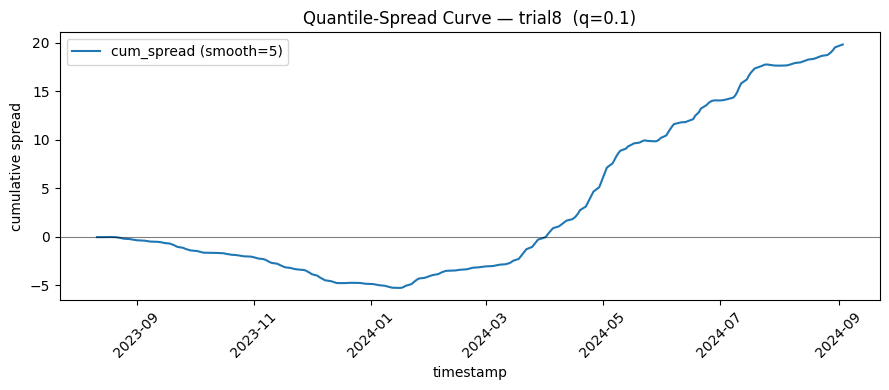

Summary:
  Days (N):        271
  Mean spread:     0.075387
  Std spread:      0.180169
  Sharpe (ann.):   6.642
  frac(spread>0):  0.576


In [46]:
spread_trial = plot_quantile_spread_curve_for_trial(
    mlp_candidates,
    "trial8",
    meta_test=meta_val,
    y_test=y_val,
    q=0.1,
    min_group_size=20,
    smooth=5,
)


## walk forward

In [47]:
import numpy as np
import pandas as pd

def daily_quantile_spread_series(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    meta: pd.DataFrame,
    time_col: str = "timestamp",
    q: float = 0.1,
    min_group_size: int = 20,
):
    df = pd.DataFrame({
        "y": y_true,
        "pred": y_pred,
        "t": pd.to_datetime(meta[time_col].values),
    })

    out = []
    for t, g in df.groupby("t"):
        if len(g) < min_group_size:
            continue
        g = g.sort_values("pred")
        n = len(g)
        k = max(int(np.floor(n * q)), 1)

        lo = g.iloc[:k]["y"].mean()
        hi = g.iloc[-k:]["y"].mean()
        out.append((t, float(hi - lo)))

    s = pd.Series(dict(out)).sort_index()
    s.name = "QuantileSpread"
    return s


def sharpe_annualized(x: pd.Series, periods_per_year: int = 252):
    mu = x.mean()
    sd = x.std(ddof=1)
    if sd == 0 or np.isnan(sd):
        return np.nan
    return float(mu / sd * np.sqrt(periods_per_year))


def rolling_sharpe_median(spread: pd.Series, window_days: int = 20):
    roll = spread.rolling(window_days)
    sharpe_roll = roll.apply(lambda w: sharpe_annualized(pd.Series(w)), raw=False)
    return float(sharpe_roll.median()), sharpe_roll


# Ejemplo en tu VAL ya entrenado:
qs_val = daily_quantile_spread_series(
    y_true=y_val_true,
    y_pred=mlp_candidates['trial8']['y_val_pred'],
    meta=meta_val,
    time_col="timestamp",
    q=0.1,
    min_group_size=20
)

med20, sharpe20 = rolling_sharpe_median(qs_val, window_days=20)
med40, sharpe40 = rolling_sharpe_median(qs_val, window_days=40)

print("Rolling Sharpe median (20d):", med20)
print("Rolling Sharpe median (40d):", med40)


Rolling Sharpe median (20d): 9.547808983549057
Rolling Sharpe median (40d): 9.774894051603344


## plot training utility

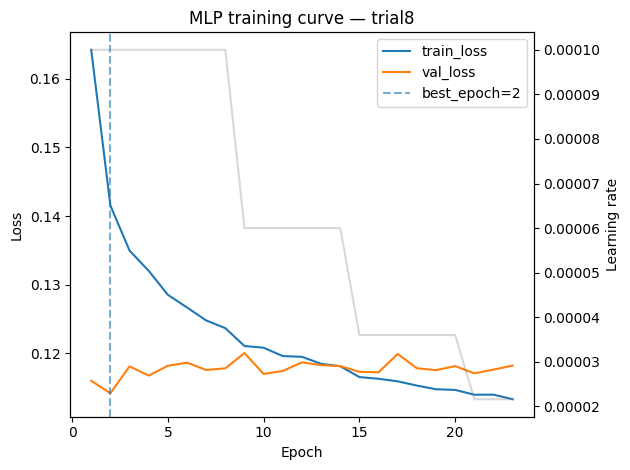

In [48]:
plot_mlp_training_curve(mlp_candidates, "trial8", smooth=1)


In [49]:
import numpy as np
import pandas as pd
from typing import Dict

def quantile_spread_cumulative_table_multi(
    pred_df: pd.DataFrame,
    score_cols: Dict[str, str],   # {"MLP":"y_pred_MLP", "Ridge":"y_pred_Ridge", ...}
    *,
    q: float = 0.1,
    min_n: int = 20,
    time_col: str = "timestamp",
    ret_col: str = "y_true",
) -> pd.DataFrame:
    """
    Returns a table with one row per timestamp.
    For each model:
      top_{name}, bot_{name}, spread_{name}, cum_spread_{name}
    """
    df = pred_df.copy()
    df[time_col] = pd.to_datetime(df[time_col])

    rows = []
    for t, g in df.groupby(time_col, sort=True):
        n = len(g)
        if n < min_n:
            continue
        k = int(np.floor(n * q))
        if k < 1:
            continue

        row = {"timestamp": t, "n": n, "k": k}

        for name, col in score_cols.items():
            if col not in g.columns:
                raise ValueError(f"Missing score column: {col}")

            g2 = g.sort_values(col)
            bot = float(g2[ret_col].iloc[:k].mean())
            top = float(g2[ret_col].iloc[-k:].mean())
            spread = float(top - bot)

            row[f"top_{name}"] = top
            row[f"bot_{name}"] = bot
            row[f"spread_{name}"] = spread

        rows.append(row)

    out = pd.DataFrame(rows).sort_values("timestamp").reset_index(drop=True)

    # cumulative spread per model
    for name in score_cols.keys():
        out[f"cum_spread_{name}"] = out[f"spread_{name}"].cumsum()

    return out


In [50]:



# print(mlp_candidates)
trial_mlp_chosen = 'trial8'
y_test_pred_mlp_chosen = mlp_candidates[trial_mlp_chosen]['y_test_pred']


y_test_pred_ridge_chosen = predict_ridge_by_run_dir(X_test, ridge_run_dir_chosen,
                                                    horizon=horizon, strict=True, fill_value=0.0)

pred_df = pd.DataFrame({'timestamp': meta_test['timestamp'], 'symbol': meta_test['symbol'], 'y_true': y_test, 'y_pred_MLP': y_test_pred_mlp_chosen,
                        'y_pred_Ridge': y_test_pred_ridge_chosen})
print(pred_df)

NameError: name 'ridge_run_dir_chosen' is not defined

In [ ]:
score_cols = {
    "MLP": "y_pred_MLP",
    "Ridge": "y_pred_Ridge",
}

qs_tbl = quantile_spread_cumulative_table_multi(
    pred_df,
    score_cols=score_cols,
    q=0.1,
    min_n=20,
)

qs_tbl.head(10)
qs_tbl.tail(10)


,timestamp,n,k,top_MLP,bot_MLP,spread_MLP,top_Ridge,bot_Ridge,spread_Ridge,cum_spread_MLP,cum_spread_Ridge
212,2025-10-03 04:00:00+00:00,82,8,0.045216,0.013611,0.031605,-0.012953,-0.250052,0.237099,-3.083109,5.491167
213,2025-10-06 04:00:00+00:00,82,8,0.001002,0.022321,-0.021320,-0.022969,-0.258197,0.235228,-3.104429,5.726395
214,2025-10-07 04:00:00+00:00,82,8,0.070392,-0.027279,0.097671,0.001226,-0.250795,0.252022,-3.006757,5.978416
215,2025-10-08 04:00:00+00:00,82,8,0.037597,0.024618,0.012979,0.021195,-0.246925,0.268120,-2.993778,6.246537
216,2025-10-09 04:00:00+00:00,82,8,0.081575,0.137145,-0.055571,0.017191,-0.237203,0.254394,-3.049349,6.500931
217,2025-10-10 04:00:00+00:00,82,8,-0.075050,0.154229,-0.229279,0.021426,-0.229775,0.251201,-3.278628,6.752132
218,2025-10-13 04:00:00+00:00,82,8,0.012154,0.051794,-0.039640,0.030309,-0.231554,0.261863,-3.318268,7.013994
219,2025-10-14 04:00:00+00:00,82,8,0.144839,0.033360,0.111479,0.022785,-0.232066,0.254851,-3.206789,7.268845
220,2025-10-15 04:00:00+00:00,82,8,0.014046,0.066514,-0.052469,0.017978,-0.234834,0.252812,-3.259258,7.521657
221,2025-10-16 04:00:00+00:00,82,8,-0.340012,0.030768,-0.370780,0.040078,-0.226435,0.266513,-3.630038,7.788170


In [ ]:
# Días con mayor spread (top-bottom) por modelo
# qs_tbl.nlargest(10, "spread_MLP")[["timestamp","n","k","top_MLP","bot_MLP","spread_MLP","cum_spread_MLP"]]
qs_tbl.nlargest(10, "spread_Ridge")[["timestamp","n","k","top_Ridge","bot_Ridge","spread_Ridge","cum_spread_Ridge"]]

# Días con peor spread
# qs_tbl.nsmallest(10, "spread_MLP")[["timestamp","n","k","top_MLP","bot_MLP","spread_MLP","cum_spread_MLP"]]


,timestamp,n,k,top_Ridge,bot_Ridge,spread_Ridge,cum_spread_Ridge
198,2025-09-15 04:00:00+00:00,82,8,0.031927,-0.242374,0.274300,2.116366
215,2025-10-08 04:00:00+00:00,82,8,0.021195,-0.246925,0.268120,6.246537
197,2025-09-12 04:00:00+00:00,82,8,0.024881,-0.241878,0.266759,1.842065
221,2025-10-16 04:00:00+00:00,82,8,0.040078,-0.226435,0.266513,7.788170
199,2025-09-16 04:00:00+00:00,82,8,0.033091,-0.232944,0.266035,2.382401
218,2025-10-13 04:00:00+00:00,82,8,0.030309,-0.231554,0.261863,7.013994
200,2025-09-17 04:00:00+00:00,82,8,0.032840,-0.228664,0.261504,2.643905
219,2025-10-14 04:00:00+00:00,82,8,0.022785,-0.232066,0.254851,7.268845
216,2025-10-09 04:00:00+00:00,82,8,0.017191,-0.237203,0.254394,6.500931
201,2025-09-18 04:00:00+00:00,82,8,0.017831,-0.236084,0.253914,2.897819


In [ ]:
# Ajusta el rango según lo que veas
mask = (qs_tbl["timestamp"] >= "2025-11-01") & (qs_tbl["timestamp"] <= "2025-11-30")
qs_tbl.loc[mask].head(50)


,timestamp,n,k,top_MLP,bot_MLP,spread_MLP,top_Ridge,bot_Ridge,spread_Ridge,cum_spread_MLP,cum_spread_Ridge


# predict against ridge

In [ ]:
from machine_learning.artifacts import load_ridge_artifact, predict_with_ridge_artifact

def build_pred_df(meta: pd.DataFrame, y_true: np.ndarray, preds: dict[str, np.ndarray]) -> pd.DataFrame:
    df = meta.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    if "target_timestamp" in df.columns:
        df["target_timestamp"] = pd.to_datetime(df["target_timestamp"])

    df["y_true"] = np.asarray(y_true, dtype=np.float64).reshape(-1)
    for name, yhat in preds.items():
        df[f"y_pred_{name}"] = np.asarray(yhat, dtype=np.float64).reshape(-1)
    return df

# Best MLP preds
yhat_mlp = mlp_candidates[trial_mlp_chosen]["y_test_pred"]

# Best Ridge preds (recompute; lightweight)
ridge_art = load_ridge_artifact(ridge_run_dir_chosen)
yhat_ridge = predict_with_ridge_artifact(ridge_art, X_test, strict=True)

pred_df = build_pred_df(
    meta=meta_test,
    y_true=np.asarray(y_test, dtype=np.float64),
    preds={
        "MLP": yhat_mlp,
        "Ridge": yhat_ridge,
    }
)

pred_df.head()


,symbol,timestamp,target_timestamp,y_true,y_pred_MLP,y_pred_Ridge
0,ABBV,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,0.007198,0.000897,0.000550
1,ADBE,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,-0.031610,0.001967,0.000319
2,AMAT,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,-0.020043,0.001574,0.000721
3,AMD,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,-0.001908,-0.002441,0.001951
4,AMGN,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,-0.002750,0.000593,0.000318


# predict against mlp

In [ ]:
preds = {}
for k, v in mlp_candidates.items():
    preds[k] = v["y_test_pred"]


pred_df = build_pred_df(
    meta=meta_test,
    y_true=np.asarray(y_test, dtype=np.float64),
    preds=preds
)

pred_df.head()

,symbol,timestamp,target_timestamp,y_true,y_pred_trial1,y_pred_trial2
0,ABBV,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,0.007198,0.000897,0.000473
1,ADBE,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,-0.031610,0.001967,0.000456
2,AMAT,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,-0.020043,0.001574,0.002796
3,AMD,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,-0.001908,-0.002441,0.000229
4,AMGN,2025-08-29 04:00:00+00:00,2025-09-02 04:00:00+00:00,-0.002750,0.000593,0.000614


# store

In [ ]:
choose_key = "trial8"
cand = mlp_candidates[choose_key]

# reconstruct model
model_to_save = MLPRegressor(
    input_dim=cand["input_dim"],
    hidden_sizes=cand["cfg"].hidden_sizes,
    dropout=cand["cfg"].dropout,
    batch_norm=cand["cfg"].batch_norm,
).cpu()

model_to_save.load_state_dict(cand["model_state"])

# reconstruct pred_df_test
pred_df_test = meta_test.copy()
pred_df_test["timestamp"] = pd.to_datetime(pred_df_test["timestamp"])
pred_df_test["target_timestamp"] = pd.to_datetime(pred_df_test["target_timestamp"])
pred_df_test["y_true"] = np.asarray(y_test, dtype=np.float64)
pred_df_test["y_pred"] = np.asarray(cand["y_test_pred"], dtype=np.float64)
pred_df_test["error"] = pred_df_test["y_pred"] - pred_df_test["y_true"]

ind_flag = int(include_indicators)
econ_flag = int(include_economic_indicators and econ_indicator_names is not None and len(econ_indicator_names) > 0)
fmp_flag = int(include_fmp)


hs = "-".join(map(str, cand["cfg"].hidden_sizes))
run_dir = (
    f"runs/mlp_{timeframe}_lb{lookback}_h{horizon}"
    f"_indicators{ind_flag}_econ{econ_flag}_fmp{fmp_flag}"
    f"_{choose_key}_hs{hs}_lr{cfg.lr}_do{cfg.dropout}_bs{cfg.batch_size}"
)


config = {
    "model": "mlp_regressor",
    "timeframe": timeframe,
    "symbols": list(symbols),
    "lookback": lookback,
    "horizon": horizon,
    "base_feature_cols": base_feature_cols,
    "include_indicators": include_indicators,
    "indicators_used": indicators_used,
    "include_economic_indicators": include_economic_indicators,
    "econ_indicator_names": econ_indicator_names,
    "include_fmp": include_fmp,
    "fmp_prefix": "fmp",
    "fmp_feature_names": fmp_feature_names,
    "keep_fmp_asof_date": keep_fmp_asof_date,
    "lags_by_feature": lags_by_feature,
    "default_lags": default_lags,
    "mlp_config": asdict(cand["cfg"]),
    "best_epoch": int(cand["history"].get("best_epoch", -1)),
    "best_val_loss": float(cand["history"].get("best_val_loss", np.nan)),
}

metrics = {
    "val": cand["metrics_val"],
    "test": cand["metrics_test"],
}

save_mlp_artifact(
    run_dir=run_dir,
    model=model_to_save,
    scaler=cand["scaler"],
    config=config,
    metrics=metrics,
    feature_names=cand["feature_names"],
    history=cand["history"],
    pred_df_test=pred_df_test,
)

print("Saved:", run_dir)


Saved: runs/mlp_1Day_lb252_h60_indicators1_econ0_fmp0_trial8_hs256-128_lr0.0001_do0.25_bs512


# Demostration

In [52]:
import datetime
from machine_learning.artifacts import predict_torch_by_run_dir

y_pred = predict_torch_by_run_dir(X_test, "runs/mlp_1Day_lb252_h60_indicators1_econ0_fmp0_trial8_hs256-128_lr0.0001_do0.25_bs512", device="cuda", strict=True)

df = meta_test.copy()
df["predicted"] = y_pred

# df

filtered = df[df['target_timestamp'] == pd.to_datetime('2026-01-14 05:00:00+00:00')]
filtered.sort_values("predicted")

,symbol,timestamp,target_timestamp,predicted
18127,SPY,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,-0.141564
18130,TSLA,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,-0.131046
18102,KLAC,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,-0.079740
18124,QQQ,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,-0.063545
18076,ASML,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,-0.055894
...,...,...,...,...
18080,BTC,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,0.082030
18078,BAC,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,0.090087
18115,MU,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,0.094502
18133,UNH,2025-10-17 04:00:00+00:00,2026-01-14 05:00:00+00:00,0.146053


In [ ]:
from machine_learning.artifacts import evaluate_saved_torch_models_extended
df_ok, df_report = evaluate_saved_torch_models_extended(
    X_val=X_val, y_val=y_val, meta_val=meta_val,
    X_test=X_test, y_test=y_test, meta_test=meta_test,
    current_lookback=lookback,
    horizon=horizon,
    runs_root="runs",
    timeframe=timeframe,
    model_names=("mlp_regressor",),   # por ahora solo MLP
    strict=True,
    fill_value=0.0,
    deadzone=calculate_deadzone(horizon),
    quantile=0.1,
    min_group_size=20,
    return_report=True,
    device="cpu",
)
df_ok


/home/aprohack/Desktop/all_folders/Investings_project/app/investenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aprohack/Desktop/all_folders/Investings_project/app/investenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aprohack/Desktop/all_folders/Investings_project/app/investenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aprohack/Desktop/all_folders/Investings_project/app/investenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,model_type,model_id,run_dir,status,skip_reason,lookback,horizon,timeframe,include_indicators,include_econ,...,test_QuantileSpread_sharpe,test_QuantileSpread_N,test_Conformal_qhat(alpha=0.1),test_Conformal_coverage(alpha=0.1),test_Conformal_avg_width(alpha=0.1),test_Conformal_width_over_std(alpha=0.1),test_Conformal_qhat(alpha=0.05),test_Conformal_coverage(alpha=0.05),test_Conformal_avg_width(alpha=0.05),test_Conformal_width_over_std(alpha=0.05)
0,mlp_regressor,mlp_1Day_lb60_h60_indicators0_econ0_fmp0_trial...,runs/mlp_1Day_lb60_h60_indicators0_econ0_fmp0_...,ok,None,60,60,1Day,0,0,...,1.516235,222,0.194352,0.827438,0.388705,1.983951,0.264069,0.905344,0.528139,2.695623
1,mlp_regressor,mlp_1Day_lb120_h60_indicators0_econ0_fmp0_tria...,runs/mlp_1Day_lb120_h60_indicators0_econ0_fmp0...,ok,None,120,60,1Day,0,0,...,-0.965317,222,0.200042,0.846281,0.400084,2.042032,0.275547,0.922810,0.551094,2.812787
